##### Notes on a framework for Simulation Engine


 - Conceptual hierarchies involved in the Simulation engine

| spatial  | Temporal |
-----------|--------------
|Studies entities based with respect to geometric / topological / etc..(see work by Klaus) |Dynamics and evolution with respect to time|
|Spatial Statistics/ Cellular Automata/ Multi Agent Systems|Discrete / Continuous / Hybrid / State space models|


 - Within the current scope, consider primarily Temporal Dynamic systems considering interactions between variables as described by a causal graph
 
 
 - The relationships between variables shall be encoded by a directed graph (or possibly be a tree) with following node and edge attributes (note that edge attributes and edge flows are interchangeable in the context of this work)
     
     - Node attributes are the function describing how to transform the values transported by all incoming edge attributes
     
     - Edge attributes are the transformations of parent node values 
     
  
 
 - Computations shall flow down the network from the exogenuous nodes (i.e. nodes with no incoming edges)

##### Data structure for simulation engine. 

Model the relationship between variables as an attributed graph, with the following attributes
 - Node attribute with dictionary keys 
     - function, which describes a transformation to be applied on to incoming flow varaibles
     - value, which describes the value of computation
     
 - Edge attribute with dictionary keys
     - function, which describes a transformation on parent node value
     
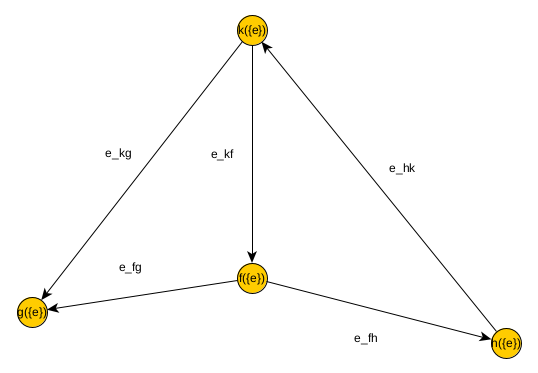


##### Challenges

- Framework we are building resembles a computational graph, however with a possibility of loops / cycles 
    - For the case of loops, we use pagerank to order the nodes
    - Challenge with self loops remain
    
- Current version of Simulation engine has been tested with I/O tables for OECD countries 
    - Note the form of I/O tables is a bit different than standard Causal Loop Diagrams


##### Class definition of Cell Dynamics (which models system dynamics within a cell)

- Constructor to initialize with graph describing network flow (to be extended to tensors in Sprint 2)
- fit_params for first pass of variables down the graph, currently supports baseline, whereby exogeneous variables get set to an initial value
- propagate_influences which desribes the core simulation paradigm, whereby the exogeneous variables are propagated down the graph (with nodes ordered by topological sorting for cycle-free graph or by pagerank for cyclic graphs)

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [23]:
class CellDynamics:
    
    def __init__(self,flow_graph = None):
        '''
        what sort of graphs do we want to allow. Ideally Digraphs with node and edge with
        2 classes of attributes, funtion and value
        '''
        self.sim_graph = flow_graph
        self.clock = 0
        self.node_values ={}
        for _node in self.sim_graph.nodes:
            self.node_values[_node] = []
        self.fit_type = None
            
    def sort_graph(self):
        # Topologically sort the graph
        try:
            self.sorted_nodes = list(nx.algorithms.dag.topological_sort(self.sim_graph))
            self.depr_sorting = False
        except:
            # in case of cycles, use pagerank to order nodes
            # Comment SDS: i thought it was just a random idea, but apparently there is some thinking along this line (https://github.com/zhenv5/breaking_cycles_in_noisy_hierarchies)
            pr = nx.pagerank(self.sim_graph)
            self.node_importance_scores = pr
            self.depr_sorting = True
            sorted_vals = sorted(pr.items(),key=lambda x:x[1],reverse=False)
            self.sorted_nodes = [_r[0] for _r in sorted_vals]
        
        
    
    def fit_params(self,node_values = {},fit_type='baseline'): 
        '''
        For the cases, where the edge attributes indicate dynamical relationships, solve the 
        dynamical system by setting exogeneous nodes to basevalues and let the flows propagate values to other nodes (fit_type baseline). 
        For ML functions, use fit()
        '''
        self.sort_graph()
        self.fit_type = fit_type    
        for _node in list(node_values.keys()):
            self.sim_graph.nodes[_node][fit_type] =node_values[_node]
        self.propagate_influences(attr_name=fit_type,normalize=False)
        #self.fit_type = fit_type
    
    
    def reset_flows(self):
        '''
        reset all edge flows / attributes to be None
        '''
        pass
    
    def clock_tick(self,**kwargs): 
        '''
        Do the bookkeeping ops with the clock tick.
        '''
        self.reset_flows()
        self.clock += 1
        #print('Tick tock %d'%(self.clock))
        self.propagate_influences()
        
    
    
    def propagate_influences(self,attr_name='val',normalize=True):
        '''
        - At the next tick, apply the functional relationship of the node on the incoming edge values
        - set the edge values of all outgoing edges to be the node computation
        '''
        #print('Propagating vals')
        
        
        for _node in self.sorted_nodes:       
            # Nothing to be done for root nodes
            #print(_node)
            if len(list(self.sim_graph.in_edges(_node))) == 0:
                #print('Root node %s' %(_node))
                pass
            #  compute node attribute transformation of incoming edge flows / attributes
            else:
                edge_vals = []
                for _edge in list(self.sim_graph.in_edges(_node)):
                    ##try:
                    if  (self.fit_type is not None) & (self.depr_sorting) & (self.node_importance_scores[_edge[0]] >= self.node_importance_scores[_node]):# Ignore edge flow as the contributing node is less important score (TBD replace it with previous cycle value)
                        if (self.clock > 1):
                            # Use the value from previous cycle
                            _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                            _parent_node_val =self.node_values[_edge[0]][self.clock - 1]
                            edge_vals.append(_edge_fn(_parent_node_val))
                        elif (self.clock == 1):
                            # Initialize the parent value to 1 
                            #print('First step %s, %s'%(_edge[0],_edge[1]))
                            _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                            _parent_node_val = nx.get_node_attributes(self.sim_graph,self.fit_type)[_edge[0]]/ nx.get_node_attributes(self.sim_graph,self.fit_type)[_edge[0]]
                            edge_vals.append(_edge_fn(_parent_node_val))
                        elif (self.clock < 1):
                            # same as above elif condition
                            _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                            try:
                                _parent_node_val = nx.get_node_attributes(self.sim_graph,self.fit_type)[_edge[0]]#1
                            except KeyError:
                                #print('TBD Parent node')
                                _parent_node_val = 1
                            edge_vals.append(_edge_fn(_parent_node_val)) 
                        else:
                            print('Should not get this far %s, %s, %s'%(self.clock,_node,_edge[0]))
                            pass 
                        
                    else:
                        # Ideal case of no cycles and topologically sorted graph
                        _edge_fn = nx.get_edge_attributes(self.sim_graph,'fn')[_edge]
                        _parent_node_val =nx.get_node_attributes(self.sim_graph,attr_name)[_edge[0]]
                        edge_vals.append(_edge_fn(_parent_node_val))
                # Compute the new node values after collecting edge values
                node_value = nx.get_node_attributes(self.sim_graph,'fn')[_node](*edge_vals) 
                if (normalize):
                    node_value = node_value / 1#self.sim_graph.nodes[_node][self.fit_type]
                self.sim_graph.nodes[_node][attr_name] = node_value 
                self.node_values[_node].append(node_value)
                
        
            
        
                
    def discrete_simulator(self,t_end,exogenous_node_vals = {}):
        '''
        Main simulation that holds all together
        '''
        for t_step in range(t_end):
            #print(t_step)
            for _node in list(exogenous_node_vals.keys()):
                #print(_node)
                self.sim_graph.nodes[_node]['val'] = exogenous_node_vals[_node][t_step]
            self.clock_tick()

##### Verification case statement - Consider one country, say Germany, "shock" (suppress) a particular sector, say "Manufacture of basic metals" and examine how the effects of this shock ripple through the economic network

- apply a random shock for 100 time steps
- apply a step change shock after a single step 

Begin by constructing economic network for Germany 

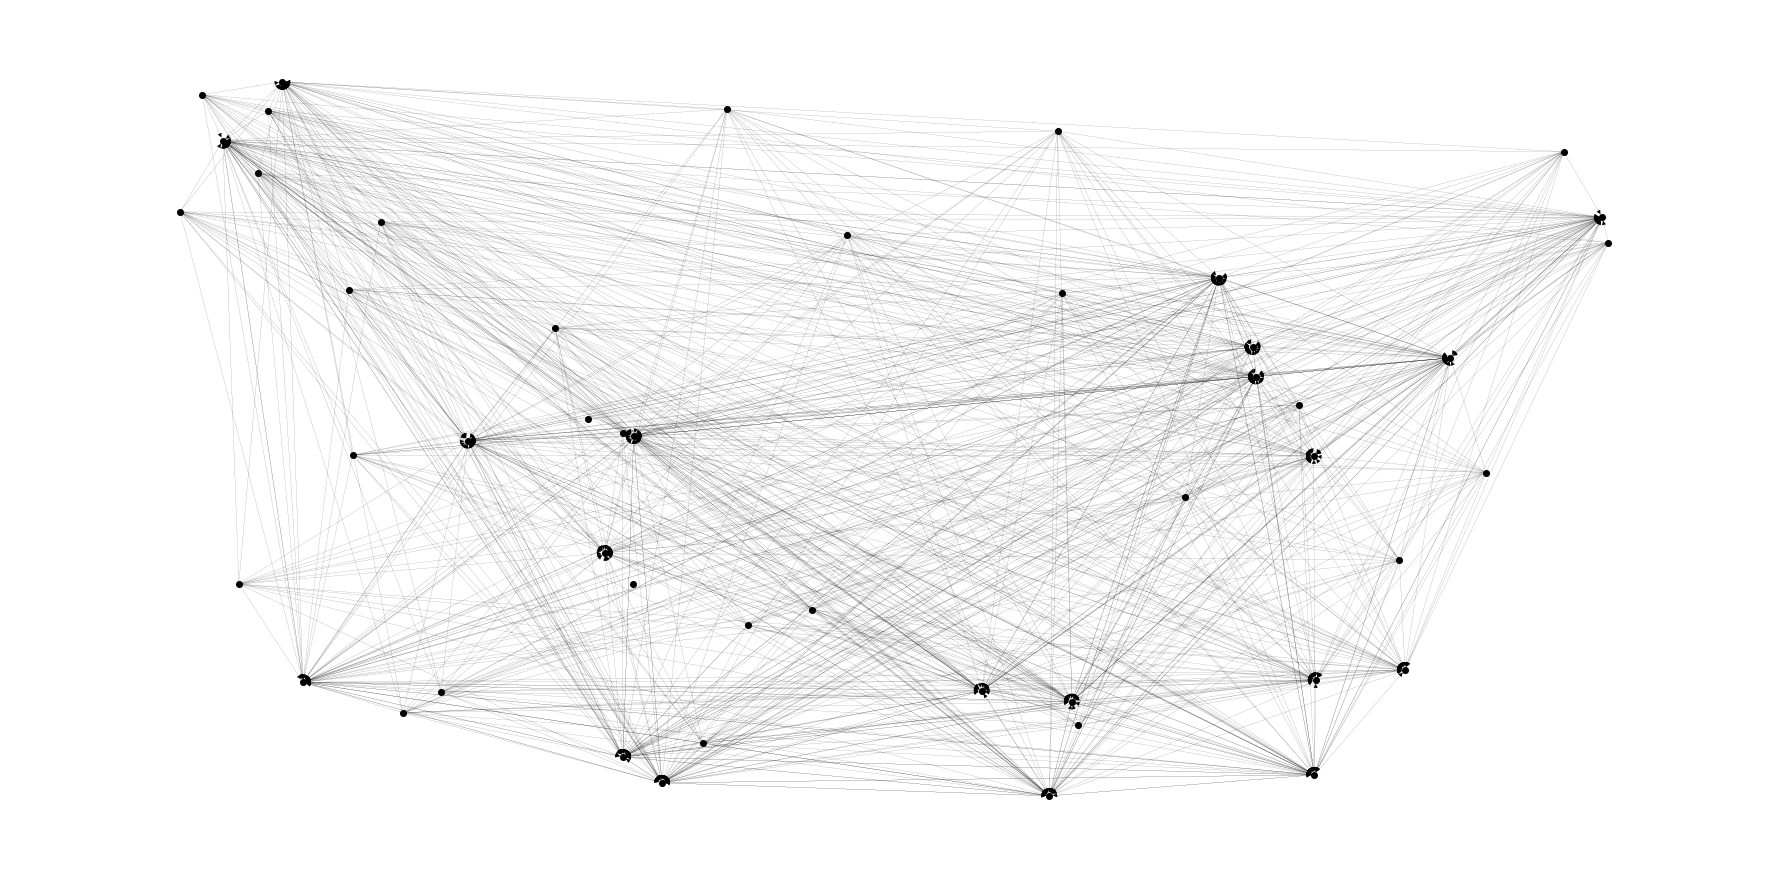

In [24]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sbs

np.random.seed(42)
%matplotlib inline

import pandas as pd
df_iots = pd.read_csv('/project_data/data_asset/sun/economy/IOTSI4_2018_Domestic.csv')

def build_economic_flow_cell(_df):
    '''
    Function to model economic activity flow within a cell as an attributed graph
    '''
    G = nx.DiGraph()
    activity = list(set(list(_df['From: (sector in row)'].values) + list(_df['To: (sector in column)'].values)))
    #print(activity)
    G.add_nodes_from(activity)
    
    nx.set_node_attributes(G,lambda *x: sum(x),name='fn')
    #nx.set_node_attributes(G,None,name=1)
    for index,row in _df.iterrows():
        #G.add_edge(row['From: (sector in row)'],row['To: (sector in column)'])
        if row['Unit'] == 'Percentage':
            G.add_edge(row['From: (sector in row)'],row['To: (sector in column)'])
            nx.set_edge_attributes(G,{(row['From: (sector in row)'],row['To: (sector in column)']):
                                         {'fn':lambda x: x*row['Value']/100,'val':row['Value']/100}})
            
        else:
            #try:
            #nx.set_edge_attributes(G,{(row['From: (sector in row)'],row['To: (sector in column)']):{'fn':lambda x:x}})
            #if len(list(simulator.sim_graph.out_edges('From: (sector in row)'))) == 0:
            #    _scale_factor = 1000000
            #else:
            #    _scale_factor = len(list(simulator.sim_graph.out_edges('From: (sector in row)')))
            _df_outgoing = _df[(_df['From: (sector in row)']==row['From: (sector in row)']) &(_df['Unit']==row['Unit'])]
            try:
                _scale_factor = row['Value']/sum(_df_outgoing['Value'])
                G.add_edge(row['From: (sector in row)'],row['To: (sector in column)'])
                nx.set_edge_attributes(G,{(row['From: (sector in row)'],row['To: (sector in column)']):{'fn':lambda x:x*_scale_factor/100,'val':_scale_factor/100}})
                #print('scaling')
            except:
                _scale_factor = 0.1
                               
            #nx.set_edge_attributes(G,{(row['From: (sector in row)'],row['To: (sector in column)']):{'fn':lambda x:x*_scale_factor/100,'val':_scale_factor/100}})
                
            #nx.set_edge_attributes(G,{(row['From: (sector in row)'],row['To: (sector in column)']):{'fn':lambda x: x/len(list(simulator.sim_graph.out_edges('From: (sector in row)')))+1}})
            #except:
            #    nx.set_edge_attributes(G,{(row['From: (sector in row)'],row['To: (sector in column)']):
            #                                 {'fn':lambda x: 0.001*x}})
                
            
        
        
    
    
    return G

# Consider that for Australia

_df = df_iots[(df_iots['Country']=='Germany') & (df_iots['Time']==2015)]

econ_flow = build_economic_flow_cell(_df)

try:
    from pyvis.network import Network
    interactive = True
except:
    try:
        !pip install pyvis
        !pip install jsonpickle
        from pyvis.network import Network
        interactive = True
    except:
        interactive = False

if interactive:
    g = Network(height=800,width=600,notebook=True)
    g.toggle_hide_edges_on_drag(True)
    g.barnes_hut()
    g.from_nx(econ_flow)
    try:
        g.show('gr1.html')
    except:
        options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,}
    plt.figure(figsize=(24,12))
    nx.draw(econ_flow,pos=nx.random_layout(econ_flow),**options)
else:
    options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,}
    plt.figure(figsize=(24,12))
    nx.draw(econ_flow,pos=nx.random_layout(econ_flow),**options)
    
#sbs.heatmap(nx.adjacency_matrix(econ_flow_aus,weight='val').toarray())
#print(list(econ_flow_aus.nodes()))



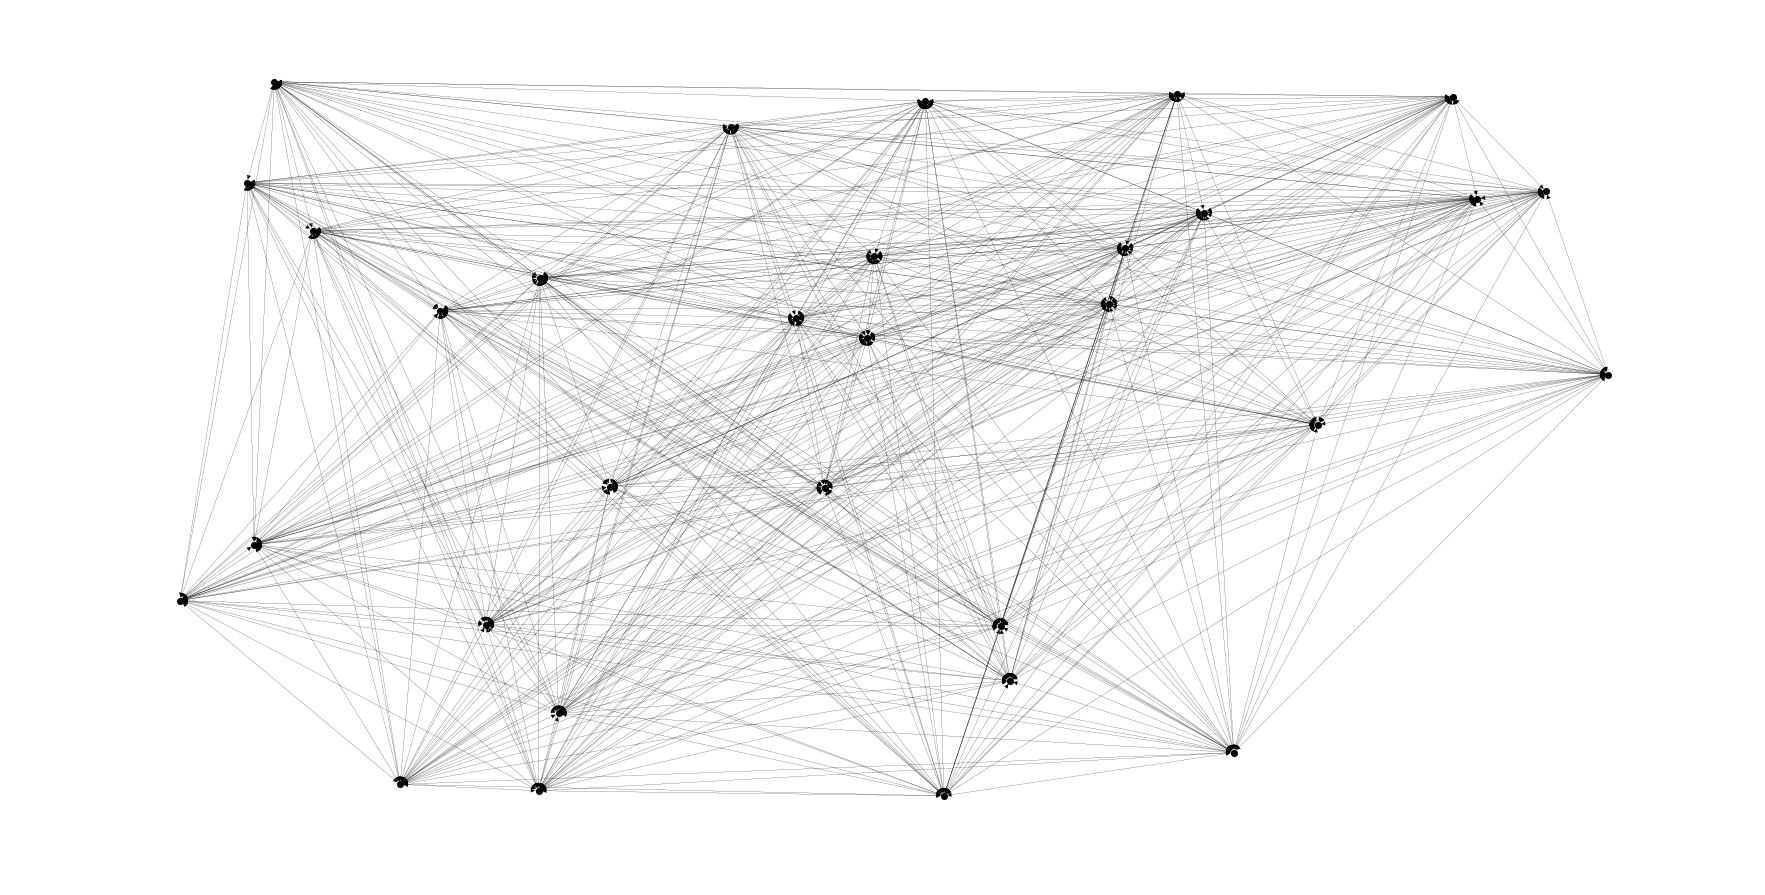

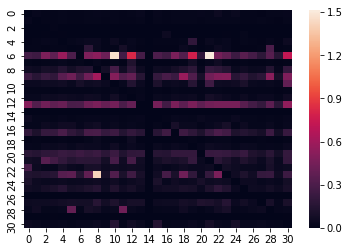

In [17]:
df_lev = pd.read_csv('/project_data/data_asset/Leontief_inverse_world.csv',low_memory=False,index_col=[0,1],skiprows=[0,1])
df_lev.columns = df_lev.index.get_level_values(1).values

def build_influence_matrix(df):
    
    #G = nx.from_numpy_matrix(df.groupby(df.columns, axis=1).sum().values,create_using=nx.DiGraph) #Not very useful as we've got enriched node and edge attrs
    G = nx.DiGraph()
    
    list_unique_sectors = list(set(df.columns))
    G.add_nodes_from(list_unique_sectors)
    nx.set_node_attributes(G,lambda *x: sum(x),name='fn')
    for _node1, row in df.iterrows():
        # ignore self-loops for the moment
        _list_other_sectors = [_node for _node in list(row.keys()) if _node!=_node1]
        for _node2 in _list_other_sectors:
            G.add_edge(_node1,_node2)
            nx.set_edge_attributes(G,{(_node1,_node2):{'fn':lambda x: x*row[_node2],'val':row[_node2]}})
        
        
    return G

df = df_lev.loc['DEU']
econ_flow = build_influence_matrix(df.groupby(df.columns, axis=1).sum())

options = {
        'node_color': 'black',
        'node_size': 50,
        'line_color': 'grey',
        'linewidths': 0,
        'width': 0.1,}
plt.figure(figsize=(24,12))
nx.draw(econ_flow,pos=nx.random_layout(econ_flow),**options)
plt.show()

plt.figure()
sbs.heatmap(nx.adjacency_matrix(econ_flow,weight='val').toarray())

In [18]:
econ_flow.nodes

NodeView(('58T60', '90T96', '09', '05T06', '23', '01T03', 'All non-essential', '16', '22', '45T47', '27', '55T56', '31T33', '69T82', '97T98', '61', '19', '49T53', '13T15', '41T43', '64T66', '28', '17T18', '20T21', '62T63', '35T39', '84', '86T88', '10T12', '85', '26'))

In [25]:
# Identify exogenoeus nodes. set values for beginning. All normalized to 1
simulator = CellDynamics(econ_flow)

exog_nodes_dict_base = {}

for _node, _in_deg in econ_flow.in_degree():
    if (_in_deg == 0):
        exog_nodes_dict_base[_node] = 1
        
# Fit the graph
    
    
simulator.fit_params(exog_nodes_dict_base)

# For exogeneous nodes, set the value of nodes for entire time window of simulation

exog_nodes_dict = {}

for _node,_in_deg in econ_flow.in_degree():
    if (_in_deg == 0):
        exog_nodes_dict[_node] = 1-0*0.1*np.random.random(100)

# Perturb one node with random shocks
exog_nodes_dict['Manufacture of basic metals'] = np.hstack((1,1 - 0.2*np.random.random(99)))#Manufacture of basic metals

    
#print(exog_nodes_dict)

#str_vals = np.random.random(100)
simulator.discrete_simulator(t_end=100,exogenous_node_vals=exog_nodes_dict)

##### Scenario # 1 ---> Random shocks causing fluctuations 

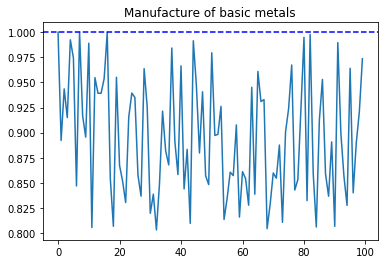

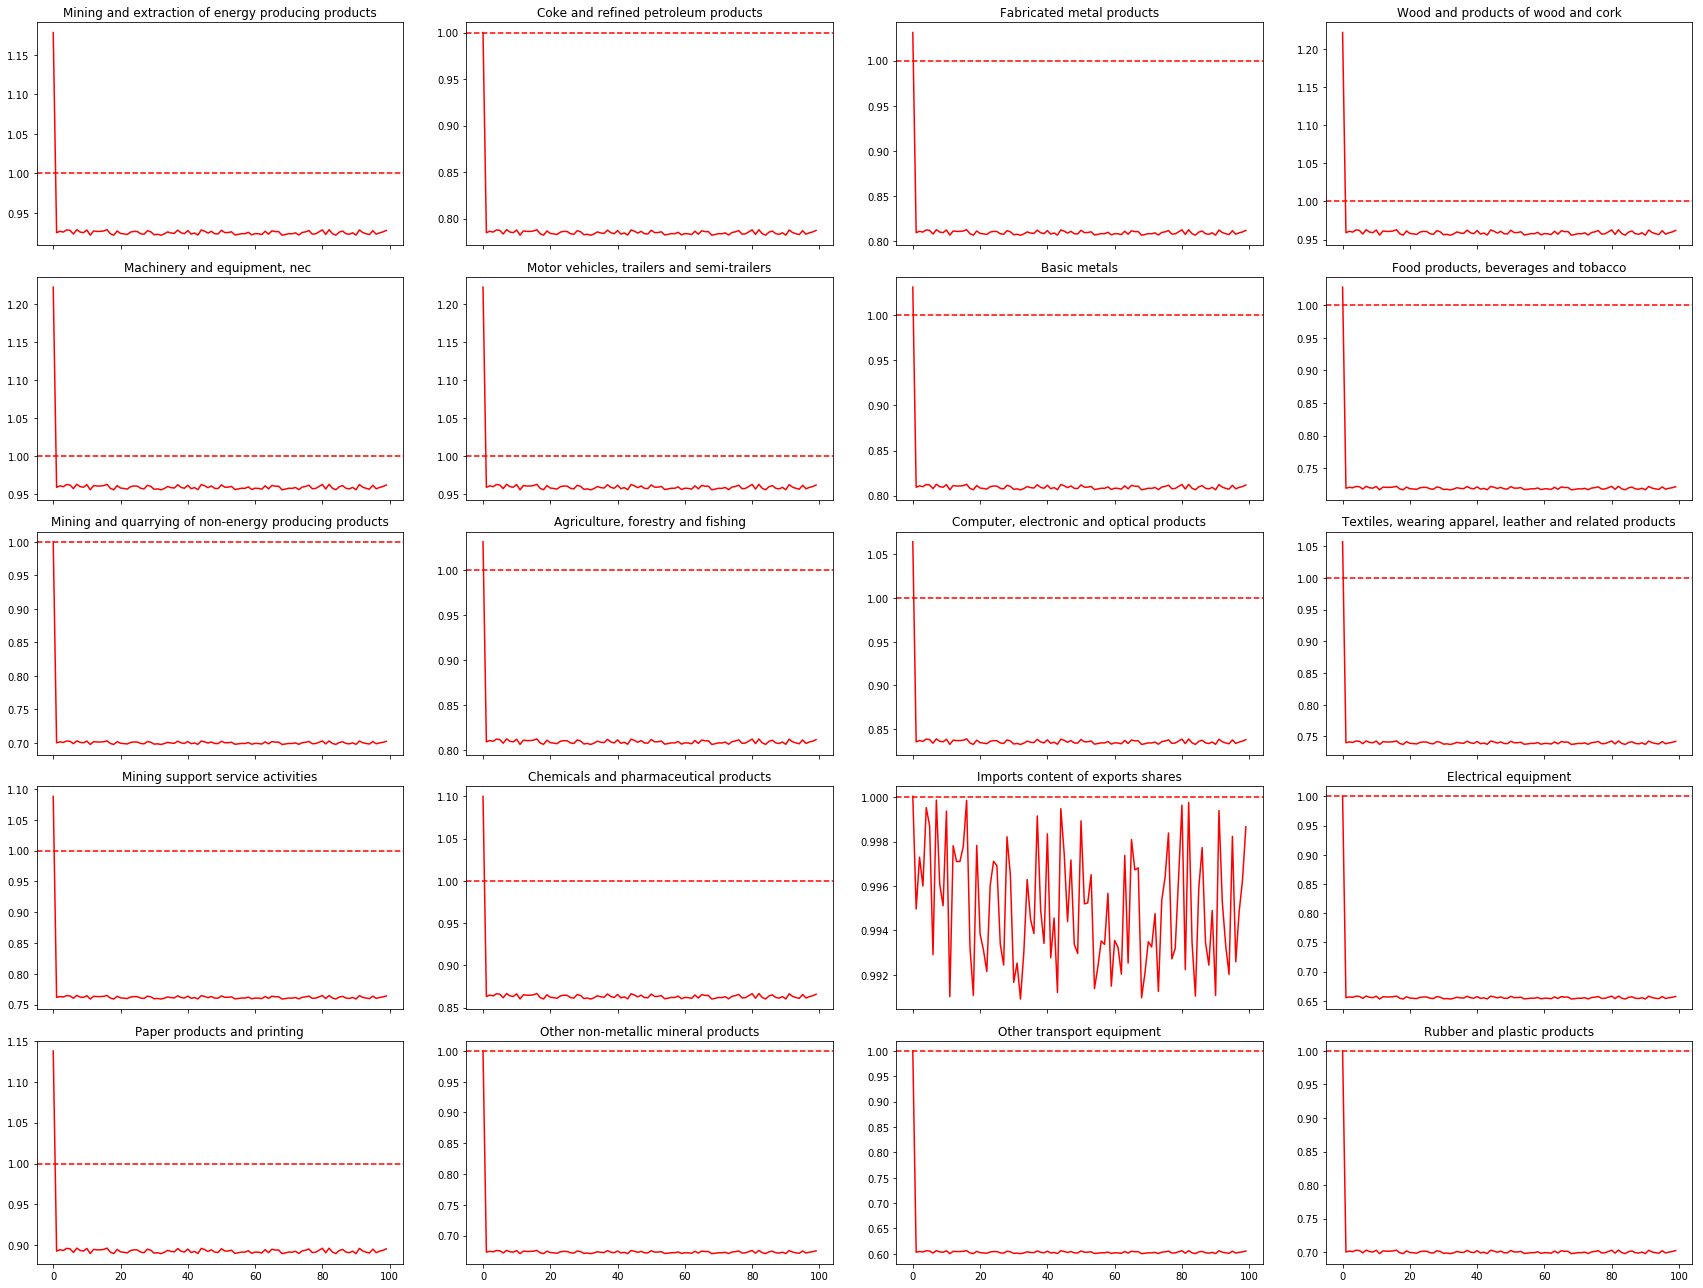

In [27]:
# Plot the exogeneous variables
import matplotlib.pyplot as plt

plt.figure()
plt.plot(exog_nodes_dict['Manufacture of basic metals'])#Manufacture of basic metals
#help(plt.axhline)
plt.axhline(1,color='b',linestyle='--')
plt.title('Manufacture of basic metals')

fig,ax = plt.subplots(5,4,figsize=(24,18),sharex=True)#(figsize=(12,8))
nodes = []
for _ax,node in zip(ax.flat,nx.algorithms.dag.descendants(econ_flow,'Manufacture of basic metals')):#simulator.node_values.keys():
    #if ctr < 100:
    #if len(simulator.node_values)>0:
    #plt.plot(np.hstack((1,simulator.node_values[node][1:])),c='r')
    _ax.plot(np.array(simulator.node_values[node][1:])/nx.get_node_attributes(simulator.sim_graph,'baseline')[node],c='r')
    _ax.axhline(nx.get_node_attributes(simulator.sim_graph,'baseline')[node]/nx.get_node_attributes(simulator.sim_graph,'baseline')[node],color='r',linestyle='--')
    _ax.set_title(node)
    nodes.append(node)
plt.tight_layout()
    #else:
    #    break

In [24]:
# Identify exogenoeus nodes
simulator = CellDynamics(econ_flow)

exog_nodes_dict_base = {}

for _node, _in_deg in econ_flow.in_degree():
    if (_in_deg == 0):
        exog_nodes_dict_base[_node] = 1
    
    
simulator.fit_params(exog_nodes_dict_base)

exog_nodes_dict = {}

for _node,_in_deg in econ_flow.in_degree():
    if (_in_deg == 0):
        exog_nodes_dict[_node] = 1-0.1*np.ones(100)

exog_nodes_dict['Manufacture of basic metals'] = np.hstack((1,1 - 0.2*np.ones(99)))

    
#print(exog_nodes_dict)

#str_vals = np.random.random(100)
simulator.discrete_simulator(t_end=100,exogenous_node_vals=exog_nodes_dict)

##### Scenario 2 ---> Suppression of activity after 1 time step

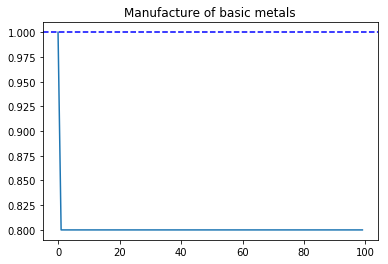

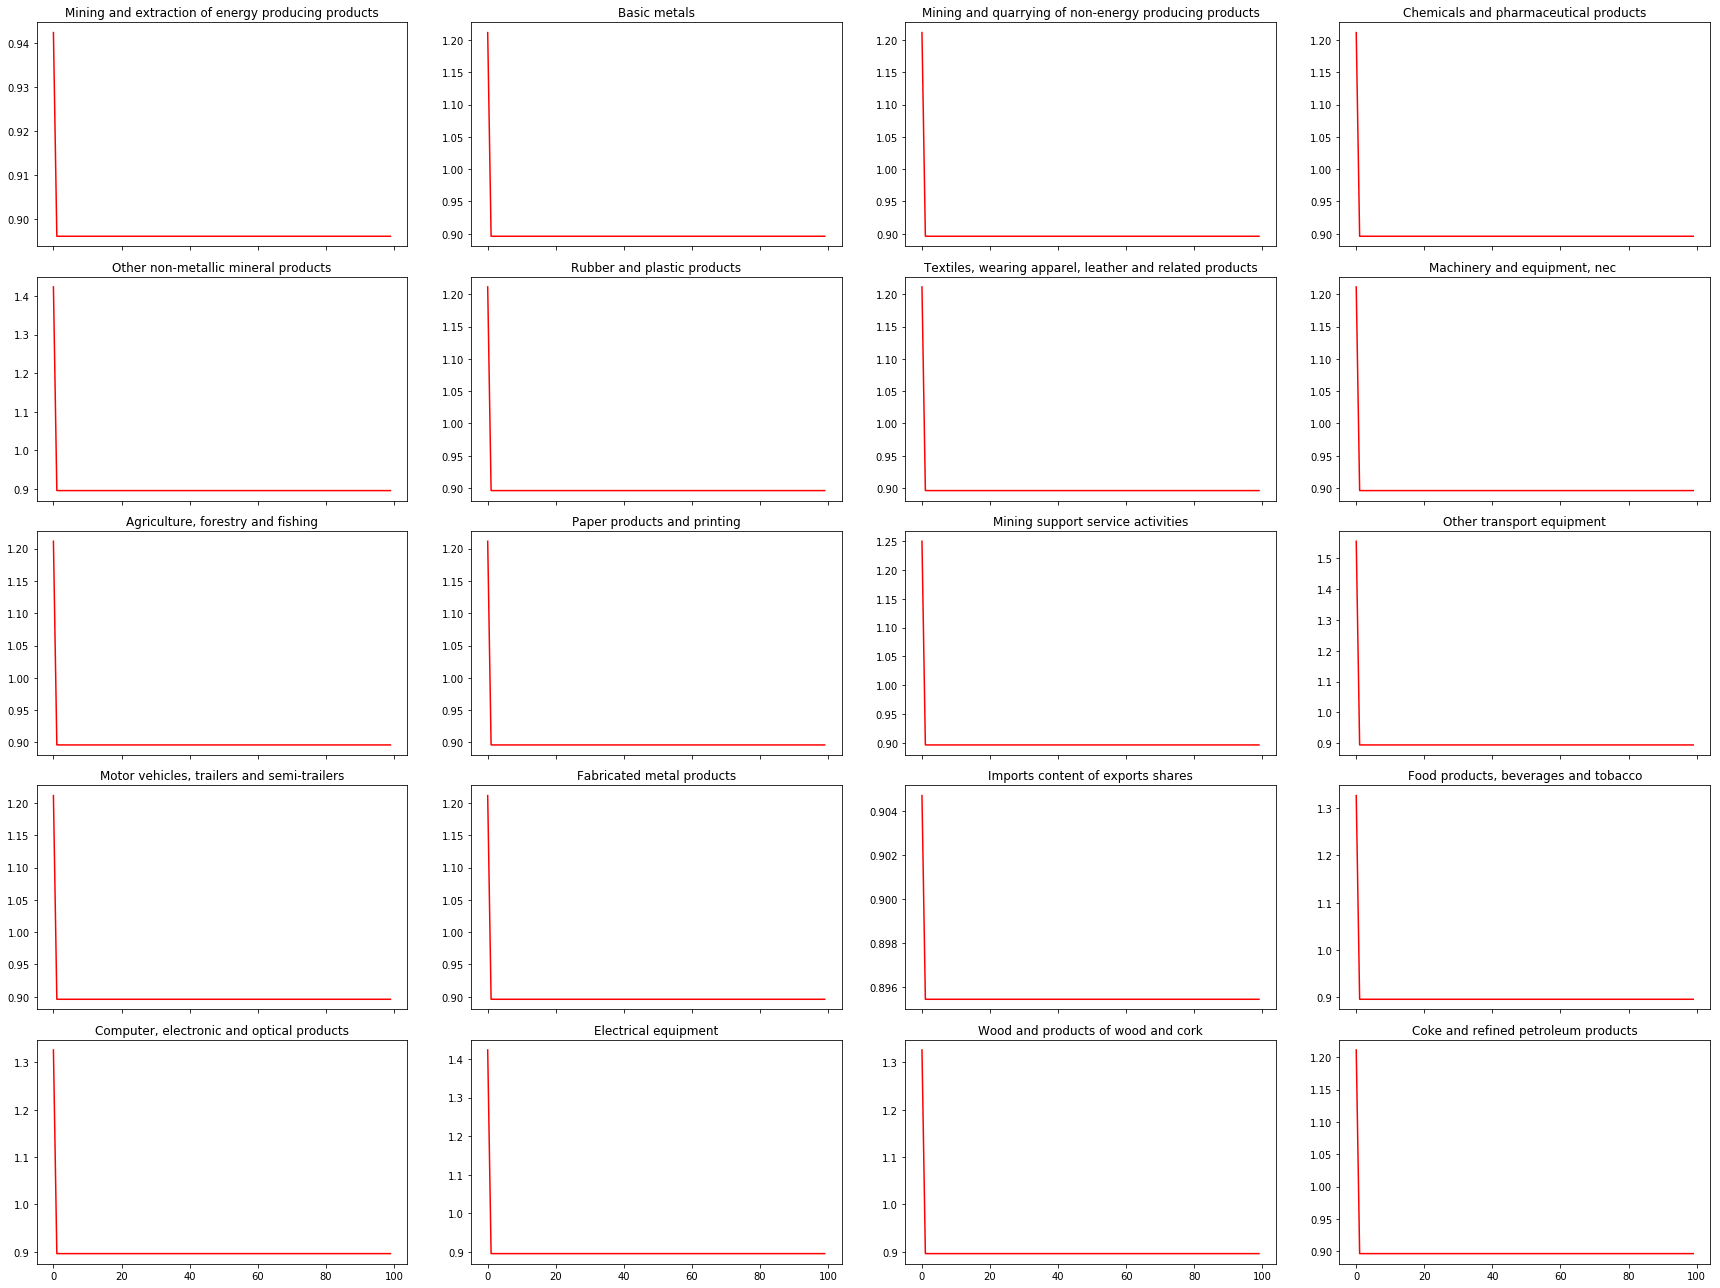

In [25]:
# Plot the exogeneous variables
import matplotlib.pyplot as plt

plt.figure()
plt.plot(exog_nodes_dict['Manufacture of basic metals'])
#help(plt.axhline)
plt.axhline(1,color='b',linestyle='--')
plt.title('Manufacture of basic metals')

fig,ax = plt.subplots(5,4,figsize=(24,18),sharex=True)#(figsize=(12,8))
nodes = []
for _ax,node in zip(ax.flat,nx.algorithms.dag.descendants(econ_flow,'Manufacture of basic metals')):#simulator.node_values.keys():
    #if ctr < 100:
    #if len(simulator.node_values)>0:
    #plt.plot(np.hstack((1,simulator.node_values[node][1:])),c='r')
    _ax.plot(np.array(simulator.node_values[node][1:])/nx.get_node_attributes(simulator.sim_graph,'baseline')[node],c='r')
    #_ax.axhline(nx.get_node_attributes(simulator.sim_graph,'baseline')[node],color='r',linestyle='--')
    _ax.set_title(node)
    #ctr = ctr + 1
    nodes.append(node)
plt.tight_layout()
    #else:
    #    break

Having satisfied that it appears okay, let us try to integrate EMA workbench into the simulation engine.

Let us initially create a simple simulation harness describing the inputs, outputs, levers and uncertainities

In [59]:
mean_node_vals = []
    
for _val in simulator.node_values.values():
    if len(_val) > 0:
        mean_node_vals.append(np.mean(_val))
    
mean_node_vals = np.array(mean_node_vals)

mean_node_vals

array([6.57825626e-04, 6.59777083e-04, 6.59777083e-04, 6.59777083e-04,
       5.08838748e-04, 6.59777083e-04, 6.59777083e-04, 1.53331552e+01,
       6.35785379e-04, 6.59777083e-04, 6.59777083e-04, 6.59777083e-04,
       6.59777083e-04, 6.35785379e-04, 6.59777083e-04, 6.59777083e-04,
       6.60055863e-04, 6.60613422e-04, 6.60613422e-04, 6.60613422e-04])

In [63]:


def run_sim_network(simulator,t_end,exog_nodes_dict_base,exog_nodes_dict):   
    simulator.fit_params(exog_nodes_dict_base)
    simulator.discrete_simulator(t_end=100,exogenous_node_vals=exog_nodes_dict)
    return simulator


def scenario_modellers(alpha,kappa):
    simulator = CellDynamics(econ_flow)
    
    exog_nodes_dict_base = {}

    for _node, _in_deg in econ_flow.in_degree():
        if (_in_deg == 0):
            exog_nodes_dict_base[_node] = alpha
            
    exog_nodes_dict = {}

    for _node,_in_deg in econ_flow.in_degree():
        if (_in_deg == 0):
            exog_nodes_dict[_node] = 1-kappa*np.random.random(100)
            
    simulator = run_sim_network(simulator,100,exog_nodes_dict_base,exog_nodes_dict)
            
    mean_node_vals = []
    
    for _val in simulator.node_values.values():
        if len(_val) > 0:
            mean_node_vals.append(np.mean(_val))
        
    mean_node_vals = np.array(mean_node_vals)
            
    return mean_node_vals

    



    

In [64]:
try:
    from ema_workbench import RealParameter, ScalarOutcome, Constant,Model, ArrayOutcome
    from ema_workbench import MultiprocessingEvaluator, ema_logging,perform_experiments
    ema_logging.log_to_stderr(ema_logging.INFO)

except ModuleNotFoundError:
    !pip install ema_workbench
    from ema_workbench import RealParameter, ScalarOutcome, Constant,Model, ArrayOutcome
    from ema_workbench import MultiprocessingEvaluator, ema_logging,perform_experiments
    ema_logging.log_to_stderr(ema_logging.INFO)

In [ ]:
model = Model('econnetwork', function=scenario_modellers)

model.uncertainties = [RealParameter('alpha', 0, 1)]
model.levers = [RealParameter('kappa', 0, 1)]

model.outcomes = [ArrayOutcome('mean_node_vals')]


with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=2, policies=4)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2 scenarios * 4 policies * 1 model(s) = 8 experiments
[ForkPoolWorker-424/ERROR] only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/em_framework/experiment_runner.py", line 85, in run_experiment
    model.run_model(scenario, policy)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/util/ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/em_framework/model.py", line 338, in run_model
    outputs = self.run_experiment(experiment)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/util/ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/sit

  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/util/ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/em_framework/model.py", line 400, in run_experiment
    value = model_output[variable]
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-pa

  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/util/ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/em_framework/model.py", line 400, in run_experiment
    value = model_output[variable]
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/em_framework/model.py", line 400, in run_experiment
    value = model_output[variable]
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

During handling of the above exception, another exception occurred:


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.6/lib/python3.6/m


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/em_framework/ema_multiprocessing.py", line 169, in worker
    return experiment, experiment_runner.run_experiment(experiment)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/ema_workbench/em_framework/experiment_runner.py", line 102, in run_experiment
    "\nCaused by: {}: {}".format(errortype, str(e))))
ema_workbench.util.ema_exceptions.EMAError: exception in run_model
Caused by: IndexError: only integers,